In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

### Testing algorithm for determining whether the mental position of the animal is ahead or behind the physical position of the animal

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import logging

FORMAT = "%(asctime)s %(message)s"

logging.basicConfig(level="INFO", format=FORMAT, datefmt="%d-%b-%y %H:%M:%S")
sns.set_context("talk")

In [3]:
from src.load_data import (
    _get_pos_dataframe,
    make_track_graph,
    classify_track_segments,
    calculate_linear_distance,
    calculate_linear_velocity,
    _calulcate_linear_position,
    EDGE_ORDER,
    EDGE_SPACING,
)


def get_position_dataframe(
    epoch_key,
    animals,
    route_euclidean_distance_scaling=1,
    sensor_std_dev=5,
    diagonal_bias=0.5,
    edge_spacing=EDGE_SPACING,
    edge_order=EDGE_ORDER,
):
    position_info = _get_pos_dataframe(epoch_key, animals)

    track_graph, center_well_id = make_track_graph()
    position = position_info.loc[:, ["x_position", "y_position"]].values

    track_segment_id = classify_track_segments(
        track_graph,
        position,
        route_euclidean_distance_scaling=route_euclidean_distance_scaling,
        sensor_std_dev=sensor_std_dev,
        diagonal_bias=diagonal_bias,
    )
    (
        position_info["linear_distance"],
        position_info["projected_x_position"],
        position_info["projected_y_position"],
    ) = calculate_linear_distance(
        track_graph, track_segment_id, center_well_id, position
    )
    position_info["track_segment_id"] = track_segment_id
    position_info["linear_position"] = _calulcate_linear_position(
        position_info.linear_distance.values,
        position_info.track_segment_id.values,
        track_graph,
        center_well_id,
        edge_order=edge_order,
        edge_spacing=edge_spacing,
    )

    position_info["linear_velocity"] = calculate_linear_velocity(
        position_info.linear_distance, smooth_duration=0.500, sampling_frequency=500
    )
    position_info["linear_speed"] = np.abs(position_info.linear_velocity)

    return position_info

In [4]:
from src.parameters import ANIMALS as animals

epoch_key = ("jaq", 1, 2)  # animal, day, epoch
position_info = get_position_dataframe(epoch_key, animals)

In [5]:
def plot_arrow(time_slice, radius=1, **kwargs):
    x = position_info.iloc[time_slice].x_position
    y = position_info.iloc[time_slice].y_position
    angle = position_info.iloc[time_slice].head_direction

    plt.arrow(x, y, radius * np.cos(angle), radius * np.sin(angle), **kwargs)

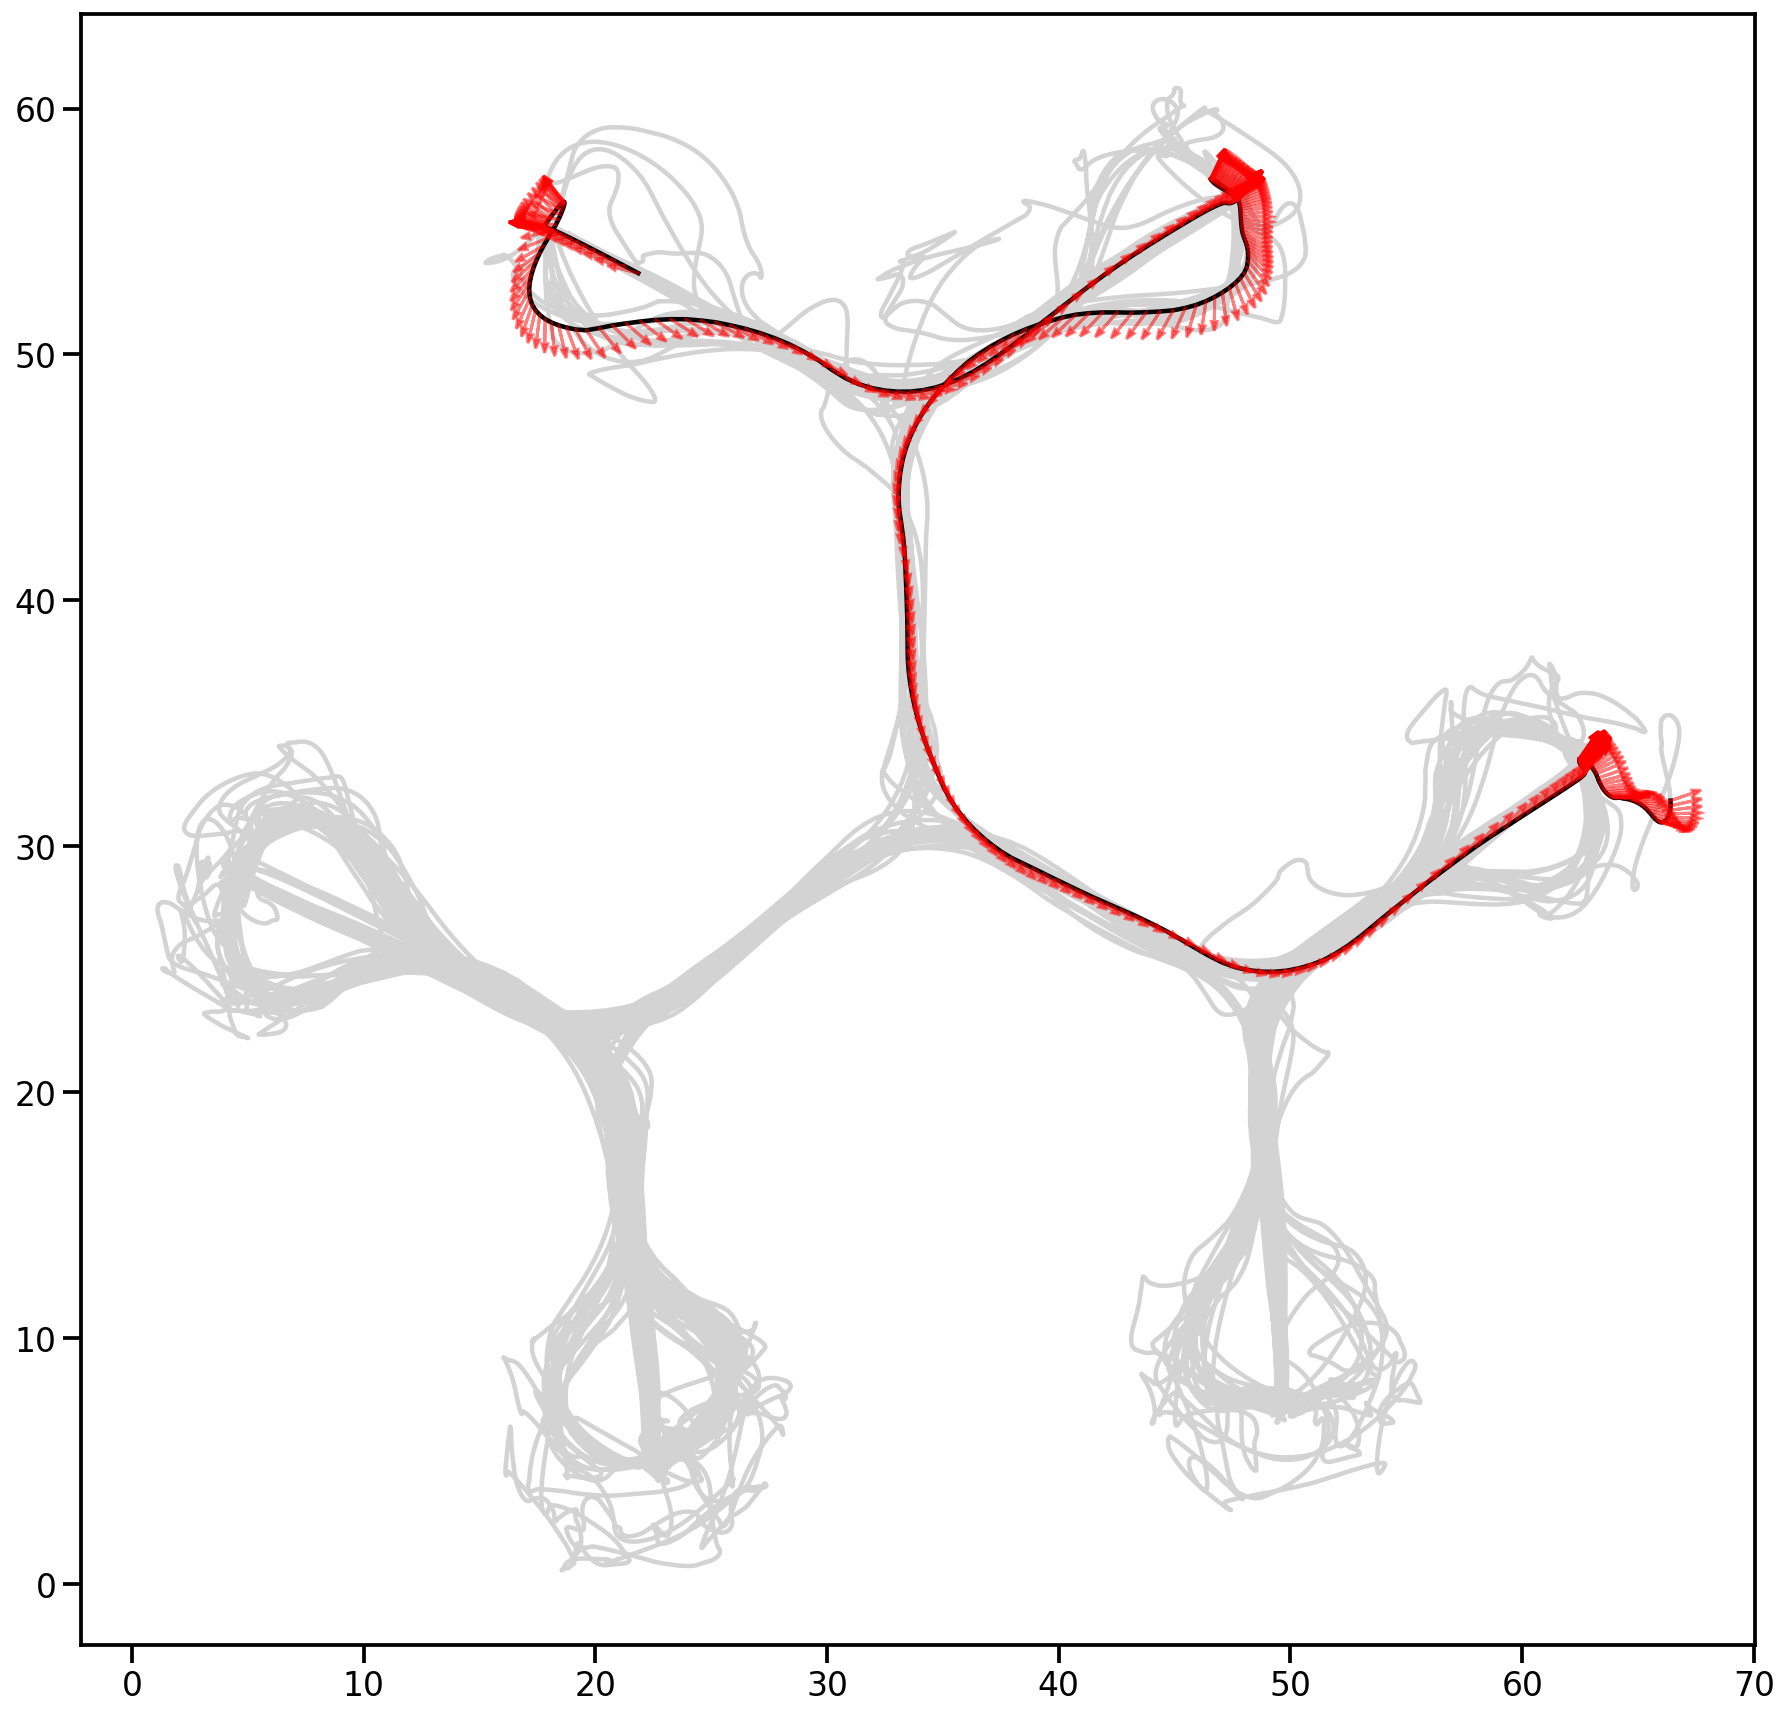

In [9]:
time_slice = slice(675, 1300)

plt.figure(figsize=(15, 15))
plt.plot(position_info.x_position, position_info.y_position, color="lightgrey")
plt.plot(
    position_info.iloc[time_slice].x_position,
    position_info.iloc[time_slice].y_position,
    color="black",
)

for ind in range(time_slice.start, time_slice.stop):
    plot_arrow(ind, radius=1, head_width=0.25, alpha=0.5, color="red", zorder=10)

In [16]:
from loren_frank_data_processing.track_segment_classification import (
    get_track_segments_from_graph,
)

track_graph, center_well_id = make_track_graph()
projected_position = position_info.iloc[time_slice][
    ["projected_x_position", "projected_y_position"]
].values
head_direction = position_info.iloc[time_slice].head_direction.values
track_segment_id = position_info.iloc[time_slice].track_segment_id.values.astype(int)

1

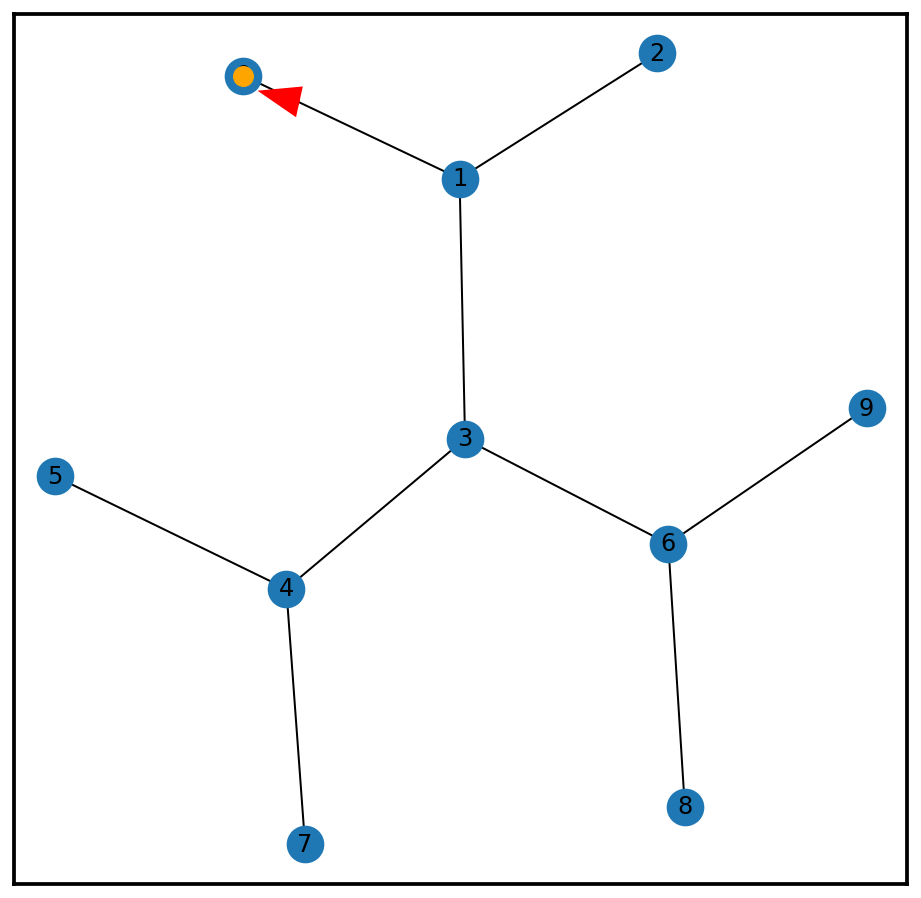

In [28]:
from src.analysis import get_ahead_or_behind
import networkx as nx

time_ind = 0
actual_pos = projected_position[time_ind]
actual_edge = np.array(track_graph.edges)[track_segment_id][time_ind]
head_dir = head_direction[time_ind]

mental_pos = track_graph.nodes[0]["pos"]
mental_edge = [0, 1]

fig, ax = plt.subplots(figsize=(8, 8))
node_position = nx.get_node_attributes(track_graph, "pos")
nx.draw_networkx(track_graph, node_position, ax)
plt.arrow(
    actual_pos[0],
    actual_pos[1],
    1e-5 * np.cos(head_dir),
    1e-5 * np.sin(head_dir),
    zorder=1000,
    head_width=1.5,
    linewidth=3,
    color="red",
)
plt.scatter(mental_pos[0], mental_pos[1], color="orange", zorder=100)

get_ahead_or_behind(
    track_graph.copy(), actual_pos, actual_edge, head_dir, mental_pos, mental_edge
)

-1

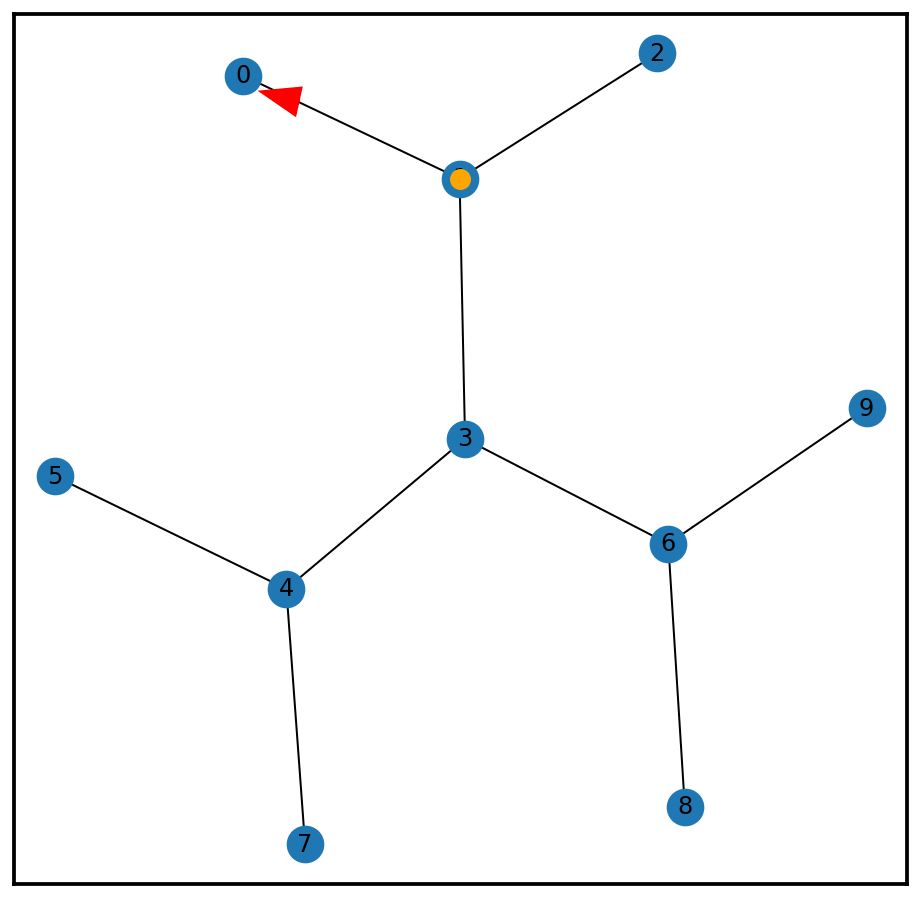

In [30]:
time_ind = 0
actual_pos = projected_position[time_ind]
actual_edge = np.array(track_graph.edges)[track_segment_id][time_ind]
head_dir = head_direction[time_ind]

mental_pos = track_graph.nodes[1]["pos"]
mental_edge = [0, 1]

fig, ax = plt.subplots(figsize=(8, 8))
node_position = nx.get_node_attributes(track_graph, "pos")
nx.draw_networkx(track_graph, node_position, ax)
plt.arrow(
    actual_pos[0],
    actual_pos[1],
    1e-5 * np.cos(head_dir),
    1e-5 * np.sin(head_dir),
    zorder=1000,
    head_width=1.5,
    linewidth=3,
    color="red",
)
plt.scatter(mental_pos[0], mental_pos[1], color="orange", zorder=100)

get_ahead_or_behind(
    track_graph.copy(), actual_pos, actual_edge, head_dir, mental_pos, mental_edge
)

-1

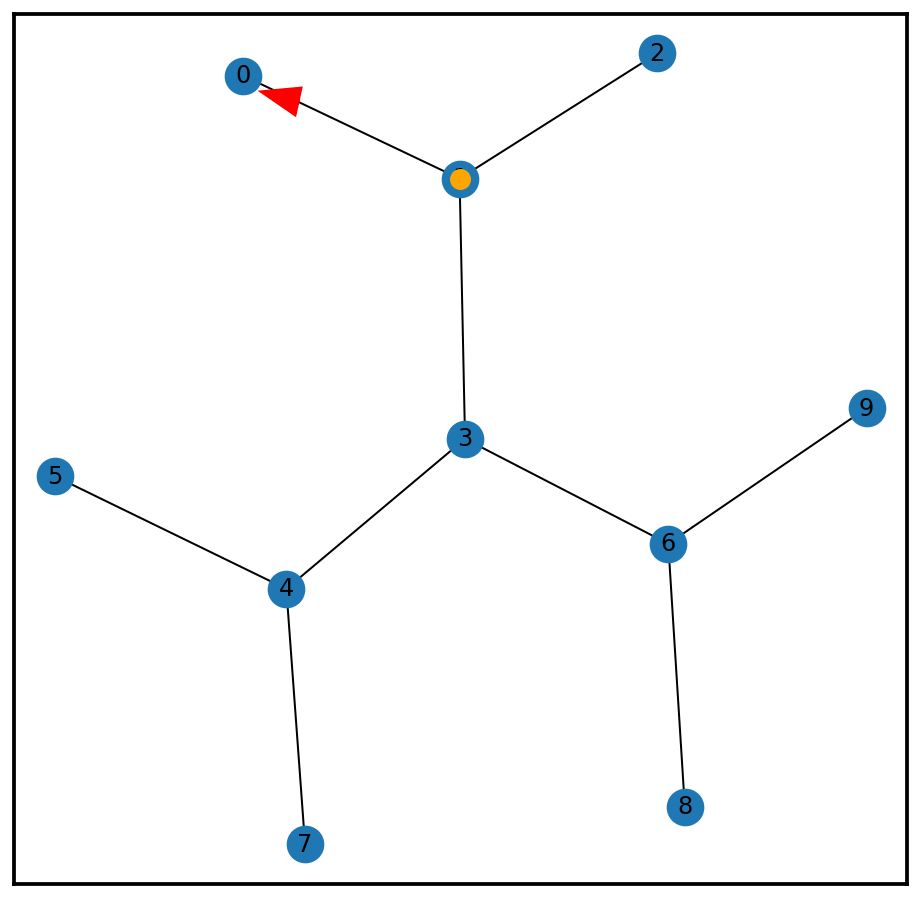

In [34]:
time_ind = 0
actual_pos = projected_position[time_ind]
actual_edge = np.array(track_graph.edges)[track_segment_id][time_ind]
head_dir = head_direction[time_ind]

mental_pos = track_graph.nodes[1]["pos"]
mental_edge = [1, 2]

fig, ax = plt.subplots(figsize=(8, 8))
node_position = nx.get_node_attributes(track_graph, "pos")
nx.draw_networkx(track_graph, node_position, ax)
plt.arrow(
    actual_pos[0],
    actual_pos[1],
    1e-5 * np.cos(head_dir),
    1e-5 * np.sin(head_dir),
    zorder=1000,
    head_width=1.5,
    linewidth=3,
    color="red",
)
plt.scatter(mental_pos[0], mental_pos[1], color="orange", zorder=100)

get_ahead_or_behind(
    track_graph.copy(), actual_pos, actual_edge, head_dir, mental_pos, mental_edge
)

-1

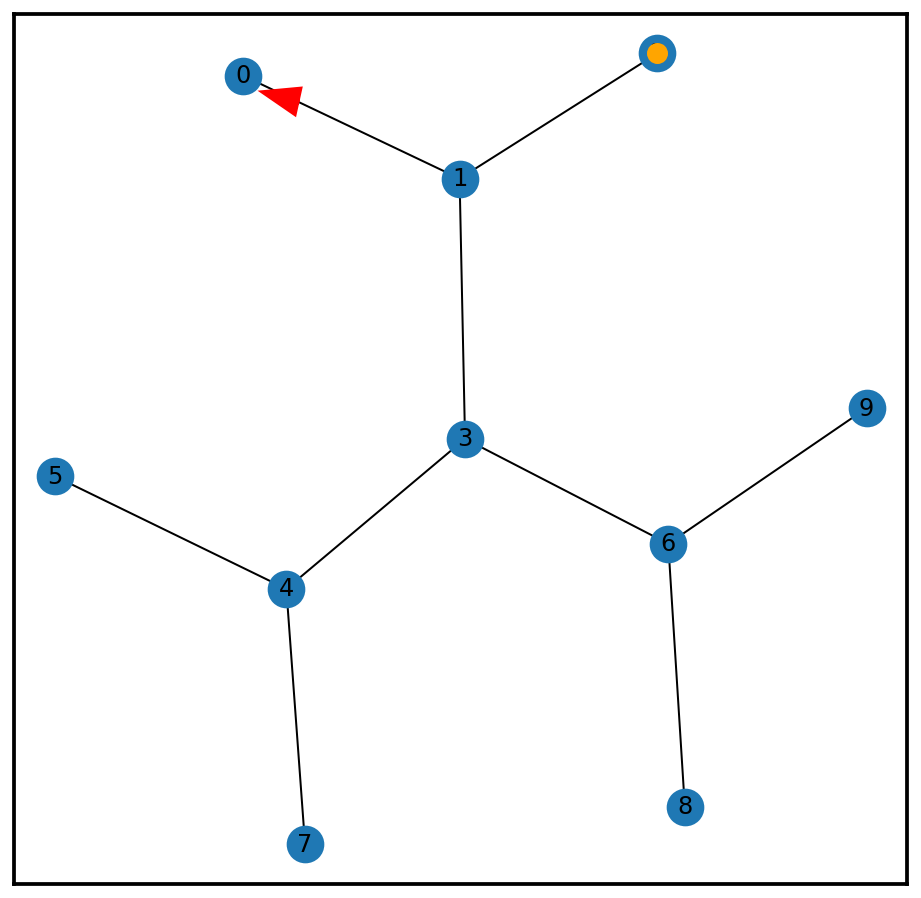

In [35]:
time_ind = 0
actual_pos = projected_position[time_ind]
actual_edge = np.array(track_graph.edges)[track_segment_id][time_ind]
head_dir = head_direction[time_ind]

mental_pos = track_graph.nodes[2]["pos"]
mental_edge = [1, 2]

fig, ax = plt.subplots(figsize=(8, 8))
node_position = nx.get_node_attributes(track_graph, "pos")
nx.draw_networkx(track_graph, node_position, ax)
plt.arrow(
    actual_pos[0],
    actual_pos[1],
    1e-5 * np.cos(head_dir),
    1e-5 * np.sin(head_dir),
    zorder=1000,
    head_width=1.5,
    linewidth=3,
    color="red",
)
plt.scatter(mental_pos[0], mental_pos[1], color="orange", zorder=100)

get_ahead_or_behind(
    track_graph.copy(), actual_pos, actual_edge, head_dir, mental_pos, mental_edge
)

1

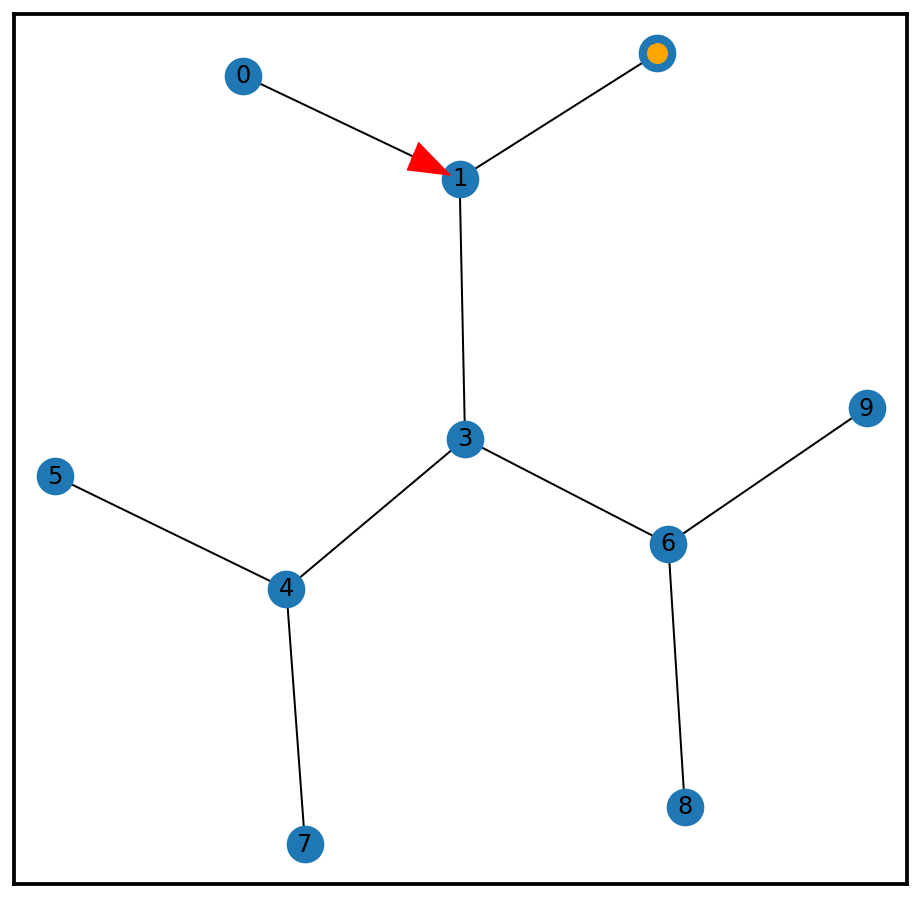

In [37]:
time_ind = 100
actual_pos = projected_position[time_ind]
actual_edge = np.array(track_graph.edges)[track_segment_id][time_ind]
head_dir = head_direction[time_ind]

mental_pos = track_graph.nodes[2]["pos"]
mental_edge = [1, 2]

fig, ax = plt.subplots(figsize=(8, 8))
node_position = nx.get_node_attributes(track_graph, "pos")
nx.draw_networkx(track_graph, node_position, ax)
plt.arrow(
    actual_pos[0],
    actual_pos[1],
    1e-5 * np.cos(head_dir),
    1e-5 * np.sin(head_dir),
    zorder=1000,
    head_width=1.5,
    linewidth=3,
    color="red",
)
plt.scatter(mental_pos[0], mental_pos[1], color="orange", zorder=100)

get_ahead_or_behind(
    track_graph.copy(), actual_pos, actual_edge, head_dir, mental_pos, mental_edge
)

-1

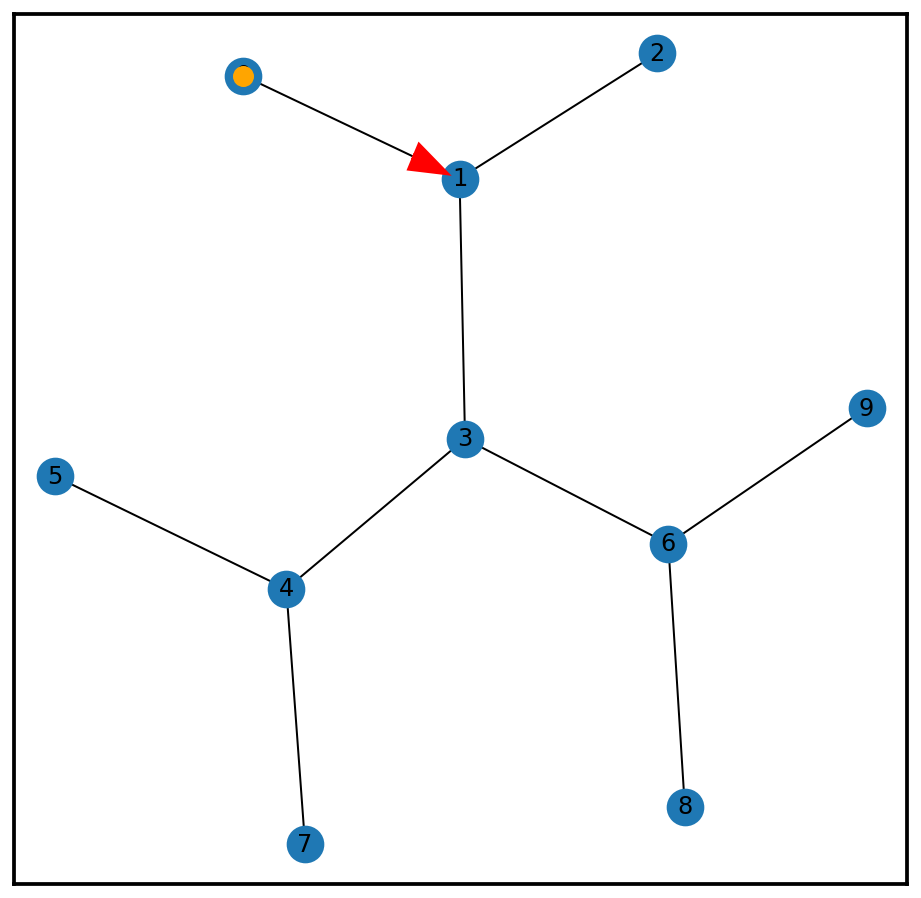

In [38]:
time_ind = 100
actual_pos = projected_position[time_ind]
actual_edge = np.array(track_graph.edges)[track_segment_id][time_ind]
head_dir = head_direction[time_ind]

mental_pos = track_graph.nodes[0]["pos"]
mental_edge = [0, 1]

fig, ax = plt.subplots(figsize=(8, 8))
node_position = nx.get_node_attributes(track_graph, "pos")
nx.draw_networkx(track_graph, node_position, ax)
plt.arrow(
    actual_pos[0],
    actual_pos[1],
    1e-5 * np.cos(head_dir),
    1e-5 * np.sin(head_dir),
    zorder=1000,
    head_width=1.5,
    linewidth=3,
    color="red",
)
plt.scatter(mental_pos[0], mental_pos[1], color="orange", zorder=100)

get_ahead_or_behind(
    track_graph.copy(), actual_pos, actual_edge, head_dir, mental_pos, mental_edge
)

1

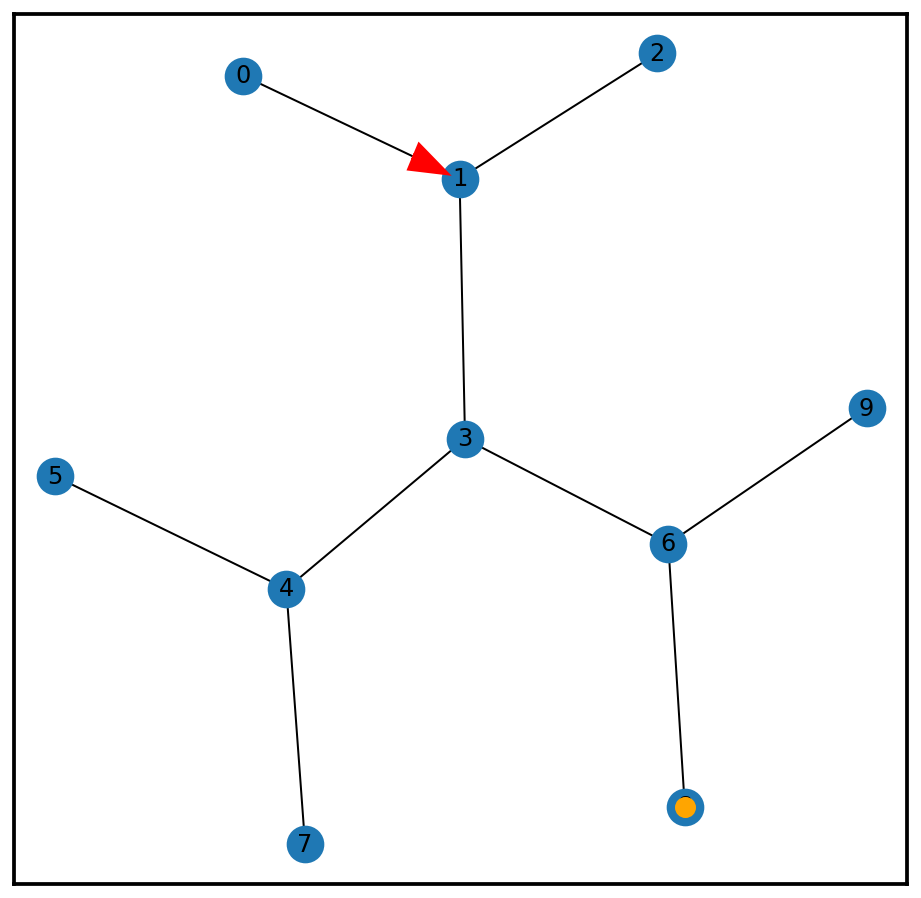

In [39]:
time_ind = 100
actual_pos = projected_position[time_ind]
actual_edge = np.array(track_graph.edges)[track_segment_id][time_ind]
head_dir = head_direction[time_ind]

mental_pos = track_graph.nodes[8]["pos"]
mental_edge = [6, 8]

fig, ax = plt.subplots(figsize=(8, 8))
node_position = nx.get_node_attributes(track_graph, "pos")
nx.draw_networkx(track_graph, node_position, ax)
plt.arrow(
    actual_pos[0],
    actual_pos[1],
    1e-5 * np.cos(head_dir),
    1e-5 * np.sin(head_dir),
    zorder=1000,
    head_width=1.5,
    linewidth=3,
    color="red",
)
plt.scatter(mental_pos[0], mental_pos[1], color="orange", zorder=100)

get_ahead_or_behind(
    track_graph.copy(), actual_pos, actual_edge, head_dir, mental_pos, mental_edge
)

-1

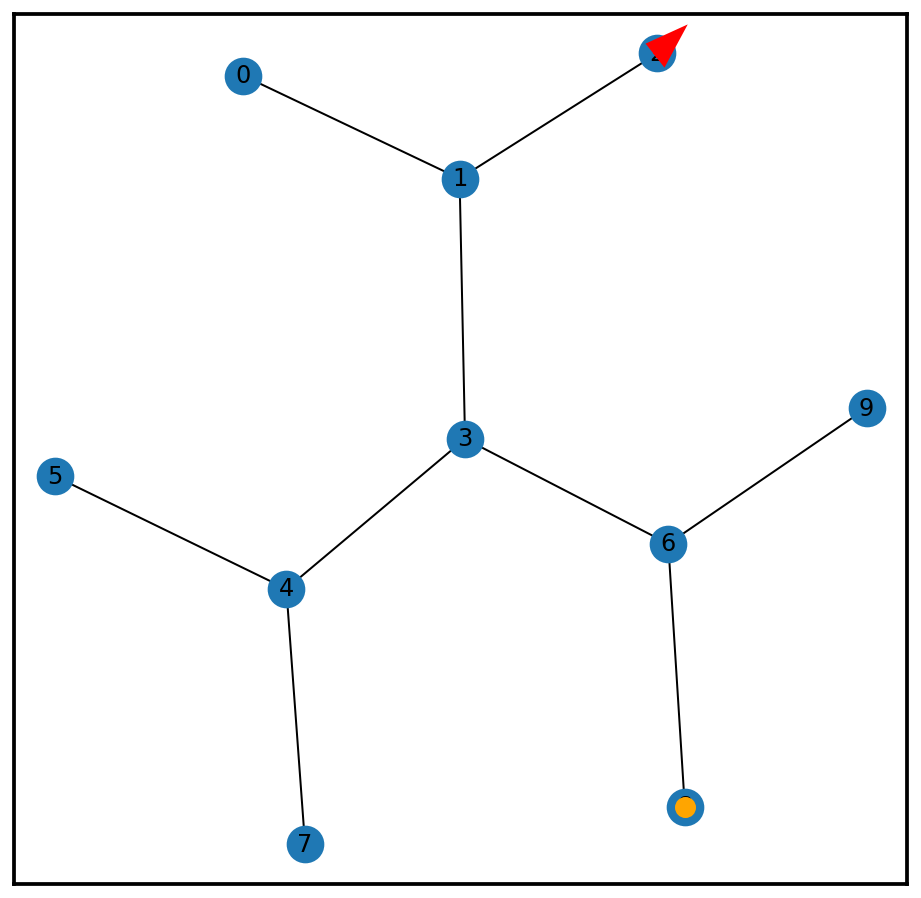

In [40]:
time_ind = 200
actual_pos = projected_position[time_ind]
actual_edge = np.array(track_graph.edges)[track_segment_id][time_ind]
head_dir = head_direction[time_ind]

mental_pos = track_graph.nodes[8]["pos"]
mental_edge = [6, 8]

fig, ax = plt.subplots(figsize=(8, 8))
node_position = nx.get_node_attributes(track_graph, "pos")
nx.draw_networkx(track_graph, node_position, ax)
plt.arrow(
    actual_pos[0],
    actual_pos[1],
    1e-5 * np.cos(head_dir),
    1e-5 * np.sin(head_dir),
    zorder=1000,
    head_width=1.5,
    linewidth=3,
    color="red",
)
plt.scatter(mental_pos[0], mental_pos[1], color="orange", zorder=100)

get_ahead_or_behind(
    track_graph.copy(), actual_pos, actual_edge, head_dir, mental_pos, mental_edge
)

0

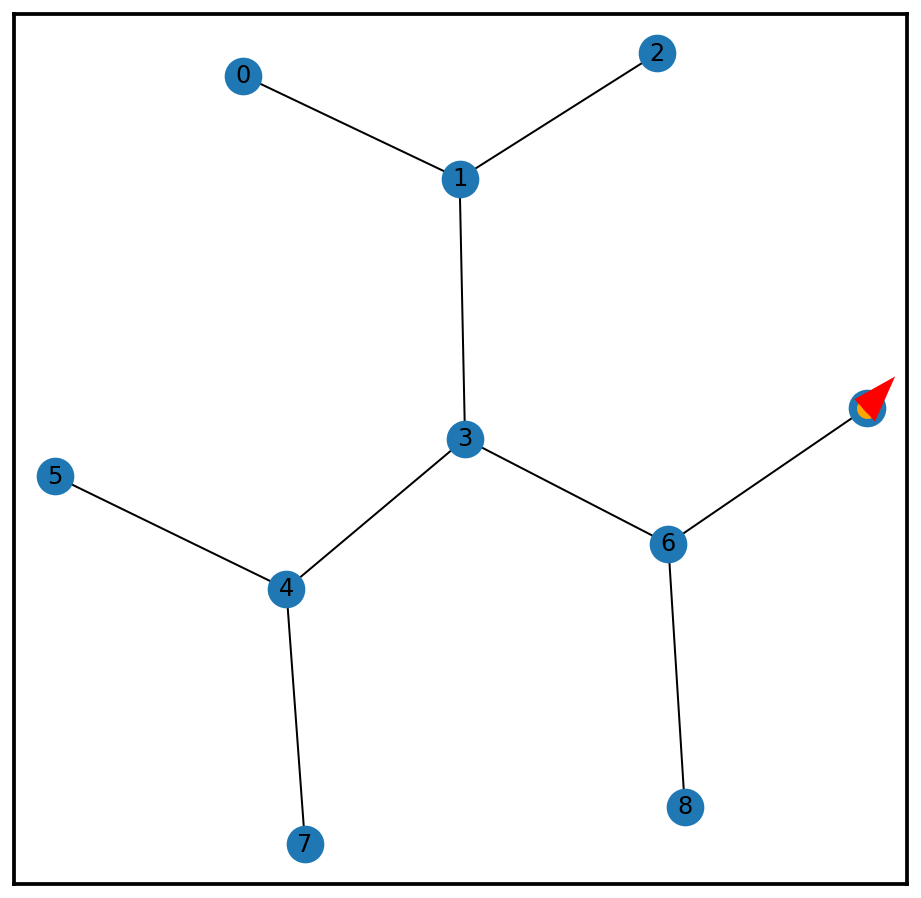

In [43]:
time_ind = 500
actual_pos = projected_position[time_ind]
actual_edge = np.array(track_graph.edges)[track_segment_id][time_ind]
head_dir = head_direction[time_ind]

mental_pos = track_graph.nodes[9]["pos"]
mental_edge = [6, 9]

fig, ax = plt.subplots(figsize=(8, 8))
node_position = nx.get_node_attributes(track_graph, "pos")
nx.draw_networkx(track_graph, node_position, ax)
plt.arrow(
    actual_pos[0],
    actual_pos[1],
    1e-5 * np.cos(head_dir),
    1e-5 * np.sin(head_dir),
    zorder=1000,
    head_width=1.5,
    linewidth=3,
    color="red",
)
plt.scatter(mental_pos[0], mental_pos[1], color="orange", zorder=100)

get_ahead_or_behind(
    track_graph.copy(), actual_pos, actual_edge, head_dir, mental_pos, mental_edge
)

1

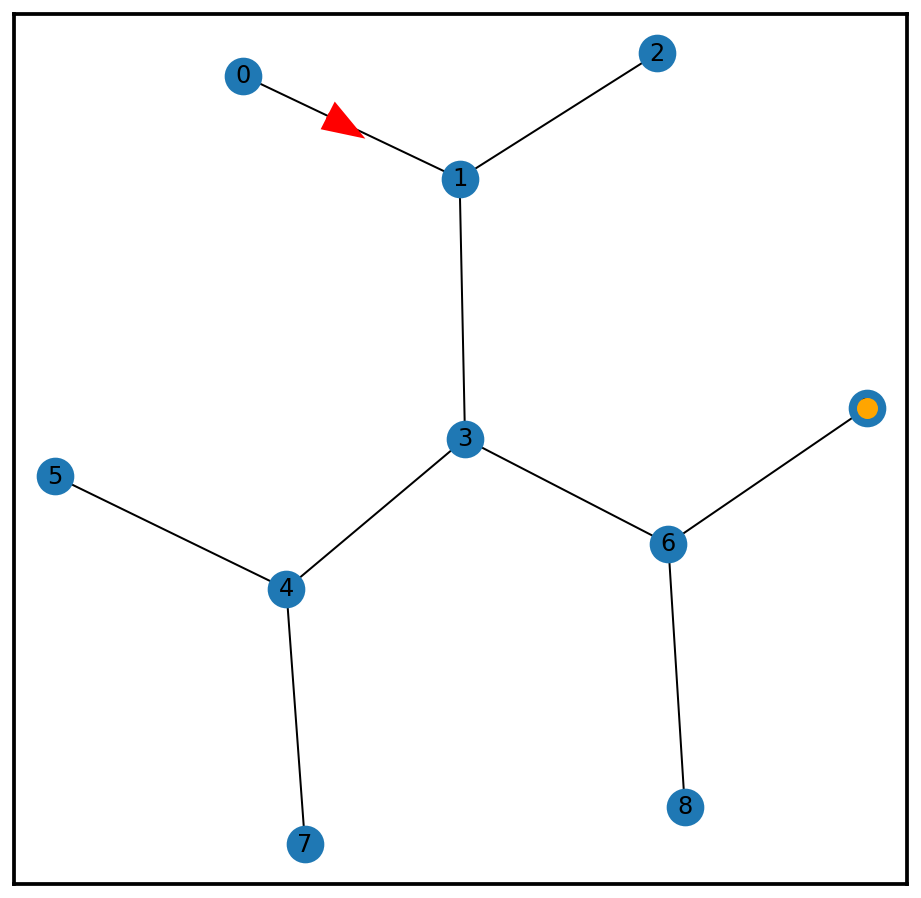

In [56]:
time_ind = 90
actual_pos = projected_position[time_ind]
actual_edge = np.array(track_graph.edges)[track_segment_id][time_ind]
head_dir = head_direction[time_ind]

mental_pos = track_graph.nodes[9]["pos"]
mental_edge = [6, 9]

fig, ax = plt.subplots(figsize=(8, 8))
node_position = nx.get_node_attributes(track_graph, "pos")
nx.draw_networkx(track_graph, node_position, ax)
plt.arrow(
    actual_pos[0],
    actual_pos[1],
    1e-5 * np.cos(head_dir),
    1e-5 * np.sin(head_dir),
    zorder=1000,
    head_width=1.5,
    linewidth=3,
    color="red",
)
plt.scatter(mental_pos[0], mental_pos[1], color="orange", zorder=100)

get_ahead_or_behind(
    track_graph.copy(), actual_pos, actual_edge, head_dir, mental_pos, mental_edge
)

1

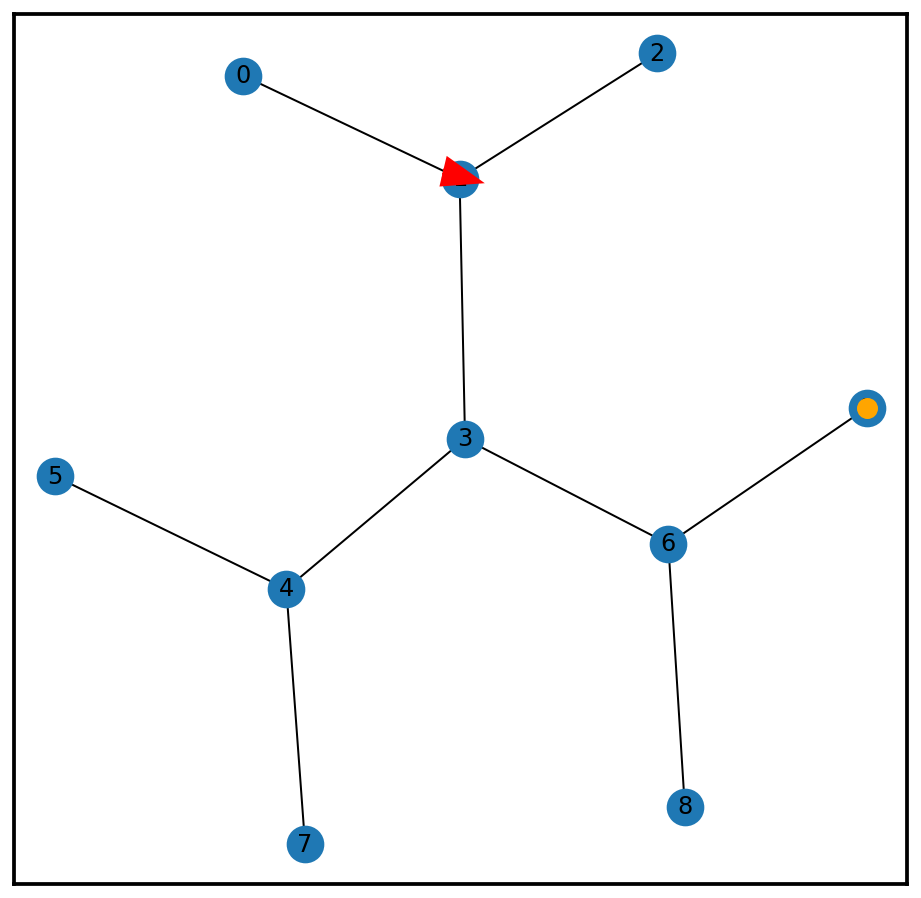

In [64]:
time_ind = 104
actual_pos = projected_position[time_ind]
actual_edge = np.array(track_graph.edges)[track_segment_id][time_ind]
head_dir = head_direction[time_ind]

mental_pos = track_graph.nodes[9]["pos"]
mental_edge = [6, 9]

fig, ax = plt.subplots(figsize=(8, 8))
node_position = nx.get_node_attributes(track_graph, "pos")
nx.draw_networkx(track_graph, node_position, ax)
plt.arrow(
    actual_pos[0],
    actual_pos[1],
    1e-5 * np.cos(head_dir),
    1e-5 * np.sin(head_dir),
    zorder=1000,
    head_width=1.5,
    linewidth=3,
    color="red",
)
plt.scatter(mental_pos[0], mental_pos[1], color="orange", zorder=100)

get_ahead_or_behind(
    track_graph.copy(), actual_pos, actual_edge, head_dir, mental_pos, mental_edge
)

-1

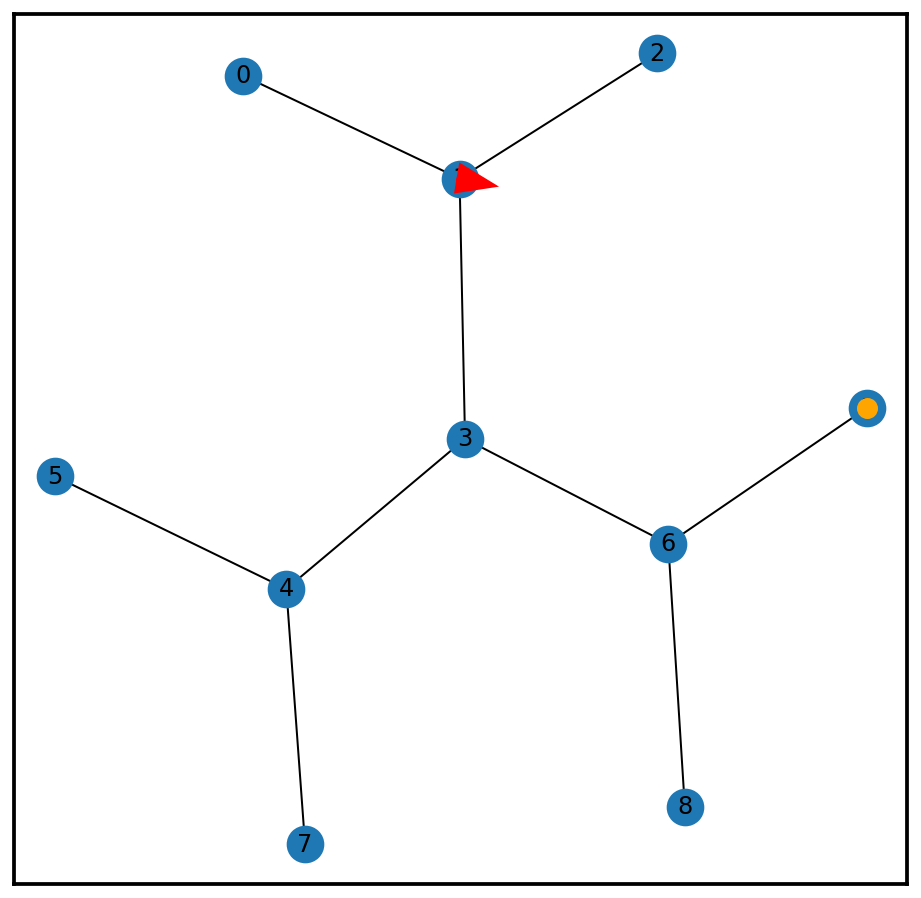

In [65]:
time_ind = 105
actual_pos = projected_position[time_ind]
actual_edge = np.array(track_graph.edges)[track_segment_id][time_ind]
head_dir = head_direction[time_ind]

mental_pos = track_graph.nodes[9]["pos"]
mental_edge = [6, 9]

fig, ax = plt.subplots(figsize=(8, 8))
node_position = nx.get_node_attributes(track_graph, "pos")
nx.draw_networkx(track_graph, node_position, ax)
plt.arrow(
    actual_pos[0],
    actual_pos[1],
    1e-5 * np.cos(head_dir),
    1e-5 * np.sin(head_dir),
    zorder=1000,
    head_width=1.5,
    linewidth=3,
    color="red",
)
plt.scatter(mental_pos[0], mental_pos[1], color="orange", zorder=100)

get_ahead_or_behind(
    track_graph.copy(), actual_pos, actual_edge, head_dir, mental_pos, mental_edge
)

array([33.778 , 39.8815])

1

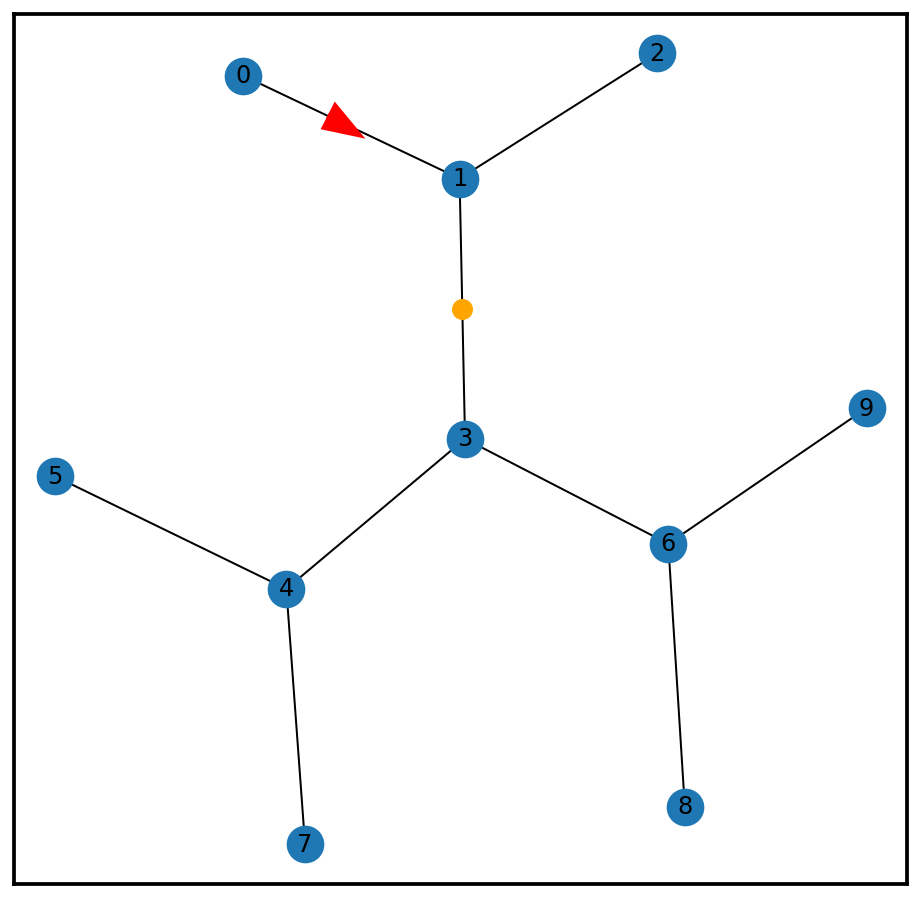

In [70]:
time_ind = 90
actual_pos = projected_position[time_ind]
actual_edge = np.array(track_graph.edges)[track_segment_id][time_ind]
head_dir = head_direction[time_ind]

mental_pos = (
    np.asarray(track_graph.nodes[1]["pos"]) + np.asarray(track_graph.nodes[3]["pos"])
) / 2
mental_edge = [1, 3]

fig, ax = plt.subplots(figsize=(8, 8))
node_position = nx.get_node_attributes(track_graph, "pos")
nx.draw_networkx(track_graph, node_position, ax)
plt.arrow(
    actual_pos[0],
    actual_pos[1],
    1e-5 * np.cos(head_dir),
    1e-5 * np.sin(head_dir),
    zorder=1000,
    head_width=1.5,
    linewidth=3,
    color="red",
)
plt.scatter(mental_pos[0], mental_pos[1], color="orange", zorder=100)

get_ahead_or_behind(
    track_graph.copy(), actual_pos, actual_edge, head_dir, mental_pos, mental_edge
)

1

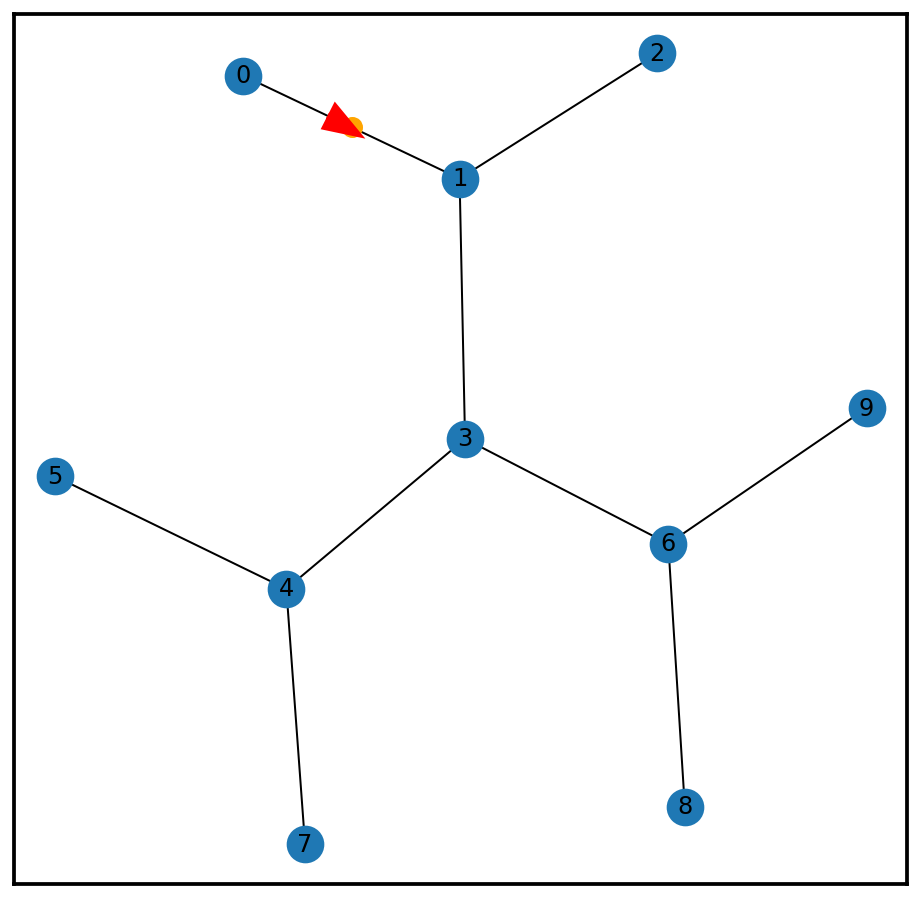

In [71]:
time_ind = 90
actual_pos = projected_position[time_ind]
actual_edge = np.array(track_graph.edges)[track_segment_id][time_ind]
head_dir = head_direction[time_ind]

mental_pos = (
    np.asarray(track_graph.nodes[0]["pos"]) + np.asarray(track_graph.nodes[1]["pos"])
) / 2
mental_edge = [0, 1]

fig, ax = plt.subplots(figsize=(8, 8))
node_position = nx.get_node_attributes(track_graph, "pos")
nx.draw_networkx(track_graph, node_position, ax)
plt.arrow(
    actual_pos[0],
    actual_pos[1],
    1e-5 * np.cos(head_dir),
    1e-5 * np.sin(head_dir),
    zorder=1000,
    head_width=1.5,
    linewidth=3,
    color="red",
)
plt.scatter(mental_pos[0], mental_pos[1], color="orange", zorder=100)

get_ahead_or_behind(
    track_graph.copy(), actual_pos, actual_edge, head_dir, mental_pos, mental_edge
)